In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

**IMAGE PREPROCESSING**

In [3]:
images_path = '../input/flickr8k-sau/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [4]:
images[:5]

['../input/flickr8k-sau/Flickr_Data/Images/3226254560_2f8ac147ea.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/214543992_ce6c0d9f9b.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2366643786_9c9a830db8.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/3368819708_0bfa0808f8.jpg',
 '../input/flickr8k-sau/Flickr_Data/Images/2190227737_6e0bde2623.jpg']

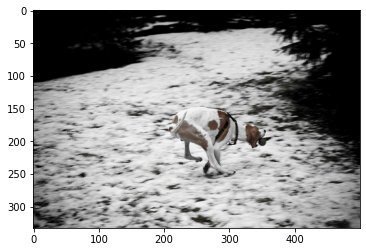

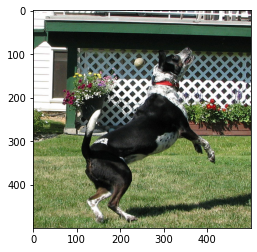

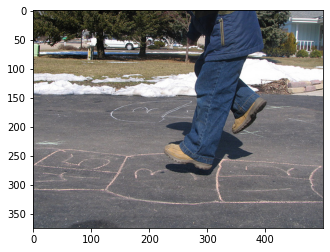

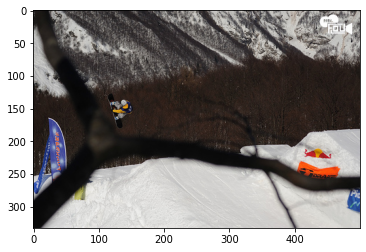

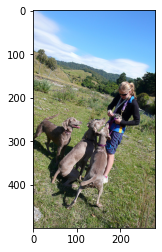

In [5]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
from tensorflow.keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

2021-10-29 17:01:52.821133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 17:01:52.912667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 17:01:52.913393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 17:01:52.914526: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)

2021-10-29 17:01:56.603801: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-29 17:01:58.191377: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [9]:
len(images_features)

1500

**Text Preprocessing**

In [10]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [11]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [12]:
len(captions)


40461

In [13]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [14]:
len(captions_dict)

1500

**Visualize Images with captions**


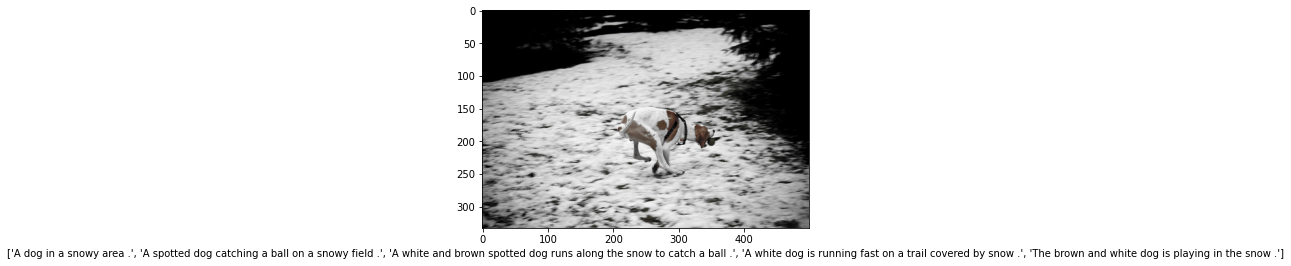

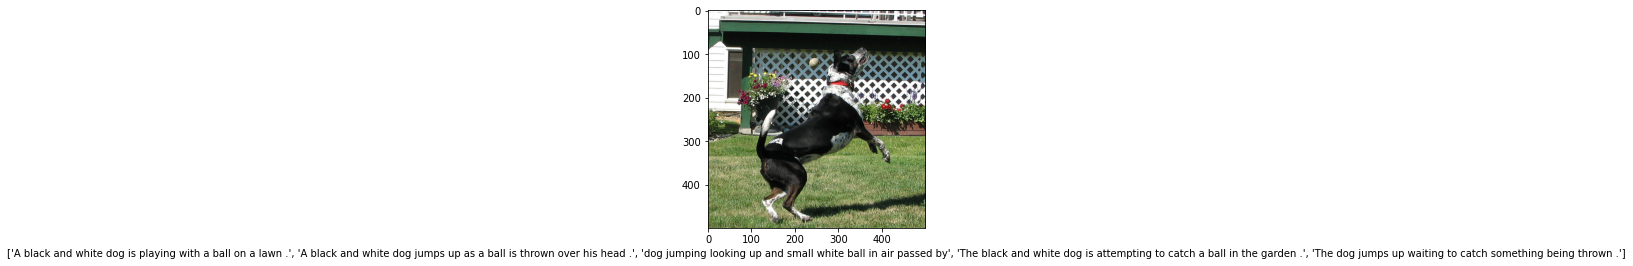

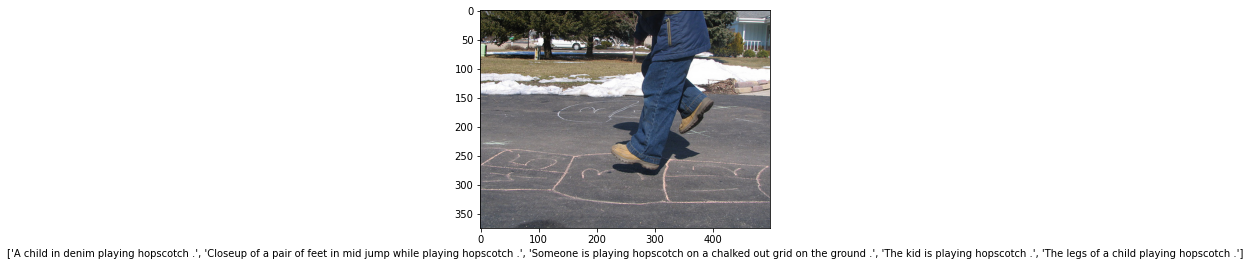

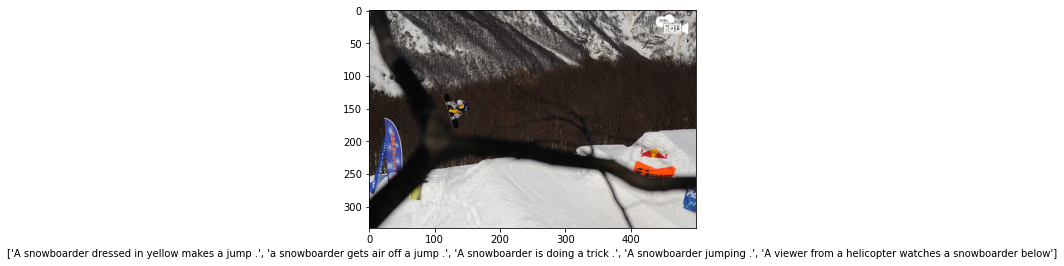

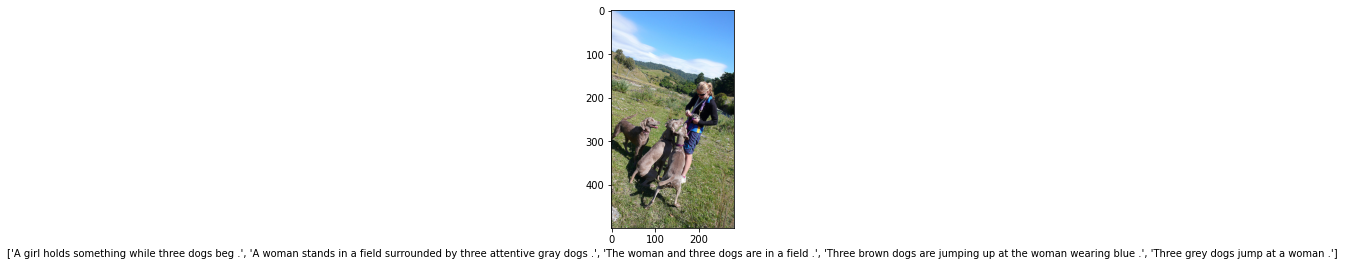

In [15]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

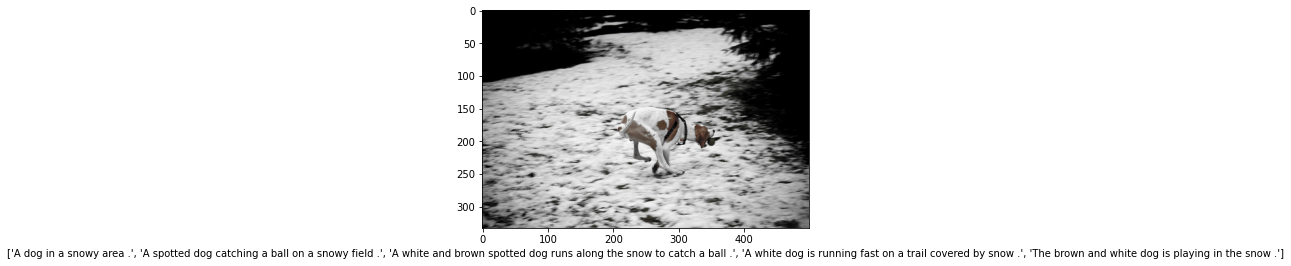

In [16]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = '../input/flickr8k-sau/Flickr_Data/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [17]:

def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified
    

In [18]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

**Creating Vocabulary**

In [19]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [20]:
len(count_words)

4073

In [21]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1

In [22]:
len(new_dict)

4073

In [23]:
new_dict['<OUT>'] = len(new_dict) 

In [24]:
captions_backup = captions_dict.copy()

In [25]:
captions_dict = captions_backup.copy()

In [26]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [27]:
captions_dict

{'1002674143_1b742ab4b8.jpg': [[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   6,
   9,
   10,
   2,
   11,
   12,
   13,
   14,
   15,
   6,
   2,
   16,
   17,
   18],
  [1, 2, 3, 4, 19, 20, 6, 9, 10, 2, 21, 11, 12, 17, 18],
  [1,
   2,
   22,
   4,
   6,
   23,
   24,
   25,
   13,
   26,
   6,
   9,
   10,
   2,
   27,
   28,
   13,
   2,
   12,
   29,
   30,
   17,
   18],
  [1, 31, 19, 2, 4, 13, 32, 20, 6, 9, 10, 2, 12, 33, 17, 18],
  [1, 34, 4, 13, 32, 33, 35, 6, 23, 24, 17, 18]],
 '102351840_323e3de834.jpg': [[1, 2, 36, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 36, 19, 37, 40, 23, 41, 39, 10, 2, 42, 17, 18],
  [1, 2, 43, 6, 23, 44, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 43, 45, 29, 2, 41, 46, 17, 18],
  [1, 47, 48, 49, 39, 50, 17, 18]],
 '1024138940_f1fefbdce1.jpg': [[1,
   47,
   51,
   52,
   10,
   53,
   54,
   27,
   55,
   56,
   29,
   23,
   57,
   17,
   18],
  [1, 47, 55, 49, 58, 2, 59, 29, 2, 60, 61, 57, 17, 18],
  [1, 47, 55, 62, 6, 23, 61, 63, 23, 57, 17, 18],
  [1

In [28]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 2, 11, 12, 13, 14, 15, 6, 2, 16, 17, 18]
[1, 2, 22, 4, 6, 23, 24, 25, 13, 26, 6, 9, 10, 2, 27, 28, 13, 2, 12, 29, 30, 17, 18]
[1, 2, 180, 190, 6, 2, 77, 191, 54, 77, 192, 193, 2, 53, 194, 121, 2, 41, 46, 54, 195, 196, 17, 18]
[1, 23, 131, 6, 23, 77, 122, 19, 706, 2, 700, 701, 467, 2, 128, 265, 23, 131, 6, 23, 245, 385, 707, 73, 621, 151, 93, 17, 18]
[1, 23, 47, 34, 178, 49, 6, 126, 54, 27, 1049, 54, 1050, 318, 281, 6, 2, 1051, 81, 322, 49, 69, 1052, 279, 2, 36, 1053, 6, 1049, 54, 2, 364, 18]
[1, 318, 188, 27, 205, 19, 35, 23, 156, 81, 472, 27, 205, 13, 2, 126, 2264, 29, 442, 298, 19, 149, 83, 2, 626, 465, 156, 318, 147, 567, 279, 2, 523, 1103, 17, 18]


In [30]:
MAX_LEN

36

In [31]:
captions_dict

{'1002674143_1b742ab4b8.jpg': [[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   6,
   9,
   10,
   2,
   11,
   12,
   13,
   14,
   15,
   6,
   2,
   16,
   17,
   18],
  [1, 2, 3, 4, 19, 20, 6, 9, 10, 2, 21, 11, 12, 17, 18],
  [1,
   2,
   22,
   4,
   6,
   23,
   24,
   25,
   13,
   26,
   6,
   9,
   10,
   2,
   27,
   28,
   13,
   2,
   12,
   29,
   30,
   17,
   18],
  [1, 31, 19, 2, 4, 13, 32, 20, 6, 9, 10, 2, 12, 33, 17, 18],
  [1, 34, 4, 13, 32, 33, 35, 6, 23, 24, 17, 18]],
 '102351840_323e3de834.jpg': [[1, 2, 36, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 36, 19, 37, 40, 23, 41, 39, 10, 2, 42, 17, 18],
  [1, 2, 43, 6, 23, 44, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 43, 45, 29, 2, 41, 46, 17, 18],
  [1, 47, 48, 49, 39, 50, 17, 18]],
 '1024138940_f1fefbdce1.jpg': [[1,
   47,
   51,
   52,
   10,
   53,
   54,
   27,
   55,
   56,
   29,
   23,
   57,
   17,
   18],
  [1, 47, 55, 49, 58, 2, 59, 29, 2, 60, 61, 57, 17, 18],
  [1, 47, 55, 62, 6, 23, 61, 63, 23, 57, 17, 18],
  [1

In [32]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
    
    

In [33]:
X, y_in, y_out = generator(images_features, captions_dict)

In [34]:
len(X), len(y_in), len(y_out)

(96528, 96528, 96528)

In [35]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [36]:
X.shape, y_in.shape, y_out.shape

((96528, 2048), (96528, 36), (96528, 4074))

In [37]:
X[1510]

array([1.4754434 , 0.21838042, 0.14905131, ..., 1.4680874 , 0.660953  ,
       0.        ], dtype=float32)

In [38]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

**Model**

In [39]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [40]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 36, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 128)           521472    
_________________________________________________________________
lstm (LSTM)                  (None, 36, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 36, 128)           32896     
Total params: 948,608
Traina

In [41]:
model.fit([X, y_in], y_out, batch_size=512, epochs=100)

2021-10-29 17:03:36.017860: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1573020288 exceeds 10% of free system memory.
2021-10-29 17:03:38.134526: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1573020288 exceeds 10% of free system memory.


Epoch 1/100
189/189 [==============================] - 16s 60ms/step - loss: 5.1436 - accuracy: 0.1464
Epoch 2/100
189/189 [==============================] - 11s 60ms/step - loss: 4.5844 - accuracy: 0.2332
Epoch 3/100
189/189 [==============================] - 11s 60ms/step - loss: 4.3979 - accuracy: 0.2547
Epoch 4/100
189/189 [==============================] - 11s 60ms/step - loss: 4.2819 - accuracy: 0.2645
Epoch 5/100
189/189 [==============================] - 11s 59ms/step - loss: 4.1647 - accuracy: 0.2757
Epoch 6/100
189/189 [==============================] - 11s 60ms/step - loss: 3.9939 - accuracy: 0.2933
Epoch 7/100
189/189 [==============================] - 11s 60ms/step - loss: 3.7994 - accuracy: 0.3119
Epoch 8/100
189/189 [==============================] - 11s 60ms/step - loss: 3.6461 - accuracy: 0.3269
Epoch 9/100
189/189 [==============================] - 11s 60ms/step - loss: 3.5211 - accuracy: 0.3398
Epoch 10/100
189/189 [==============================] - 11s 60ms/step - l

In [42]:
inv_dict = {v:k for k, v in new_dict.items()}

In [43]:
model.save('model.h5')

In [44]:
model.save_weights('mine_model_weights.h5')

In [45]:
np.save('vocab.npy', new_dict)

In [46]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

**Predictions**

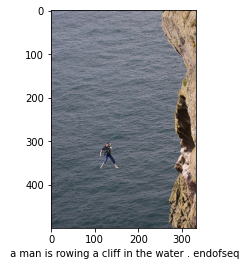

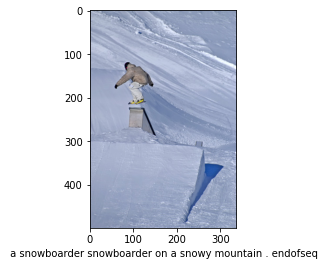

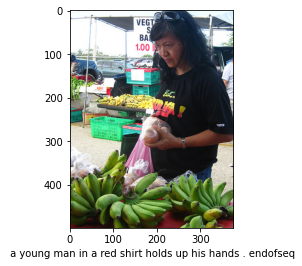

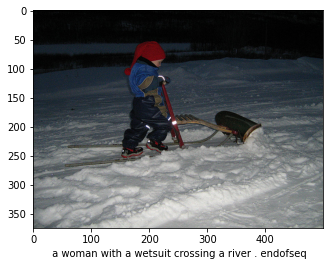

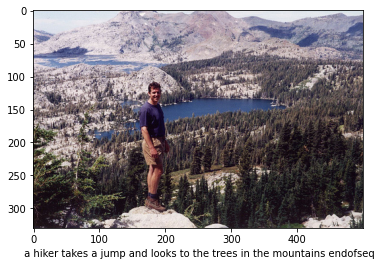

In [53]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)